In [1]:
# Подключение к Google Диску
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Распаковка архива с изображениями 
!unzip "/content/gdrive/MyDrive/object_detection_in_image/input.zip"  

Archive:  /content/gdrive/MyDrive/object_detection_in_image/input.zip
   creating: input/
  inflating: input/image_1.jpg       
  inflating: input/image_2.jpg       
  inflating: input/image_3.jpg       
  inflating: input/image_4.jpg       
  inflating: input/image_5.jpg       


In [3]:
# Создание папки в которой будет результат работы модели 
!mkdir outputs 

In [4]:
# Импортируем библиотеку для визуализации
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 21, 18

In [5]:
# Записываем имена категорий как python файл
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Writing coco_names.py


In [6]:
# скрипт для обнаружения как python файл
%%writefile detect_utils.py

import torchvision.transforms as transforms
import cv2
import numpy
import numpy as np
from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names


# создаем разные цвета для каждого класса
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))


# определяем преобразование изображения
transform = transforms.Compose([
    transforms.ToTensor(),
])


def predict(image, model, device, detection_threshold):
    # перевод изображения в тензор
    image = transform(image).to(device)
    image = image.unsqueeze(0) # добавляем пакетное измерение
    outputs = model(image) # получаем предсказания по изображению
    # получаем все предсказанные имена классов
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # получаем score за все предсказанные объекты
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # получаем все предсказанные ограничивающие рамки
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # получаем ограничивающие рамки выше порогового балла
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    return boxes, pred_classes, outputs[0]['labels']


def draw_boxes(boxes, classes, labels, image):
    # читаем изображение с помощью OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Writing detect_utils.py


In [7]:
# обнаружение объектов на изображениях как python файл
%%writefile detect_img.py
import torchvision
import torch
import argparse
import cv2
import detect_utils

from PIL import Image

# собираем парсер аргументов
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image/video')
args = vars(parser.parse_args())

# определяем вычислительное устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# загружаем модель 
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# загружаем модель на вычислительное устройство
model.eval().to(device)

# читаем изображение и запускаем вывод для обнаружения
image = Image.open(args['input'])
boxes, classes, labels = detect_utils.predict(image, model, device, 0.7)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
# cv2.imshow('Image', image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2.imwrite(f"outputs/{save_name}.jpg", image)
# cv2.waitKey(0)

Writing detect_img.py


In [8]:
# запускаем detect_img.py файл с входом изображений для обнаружения обьектов 
!python detect_img.py --input input/image_1.jpg
!python detect_img.py --input input/image_2.jpg
!python detect_img.py --input input/image_3.jpg
!python detect_img.py --input input/image_4.jpg
!python detect_img.py --input input/image_5.jpg

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100% 74.2M/74.2M [00:00<00:00, 249MB/s]
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained'

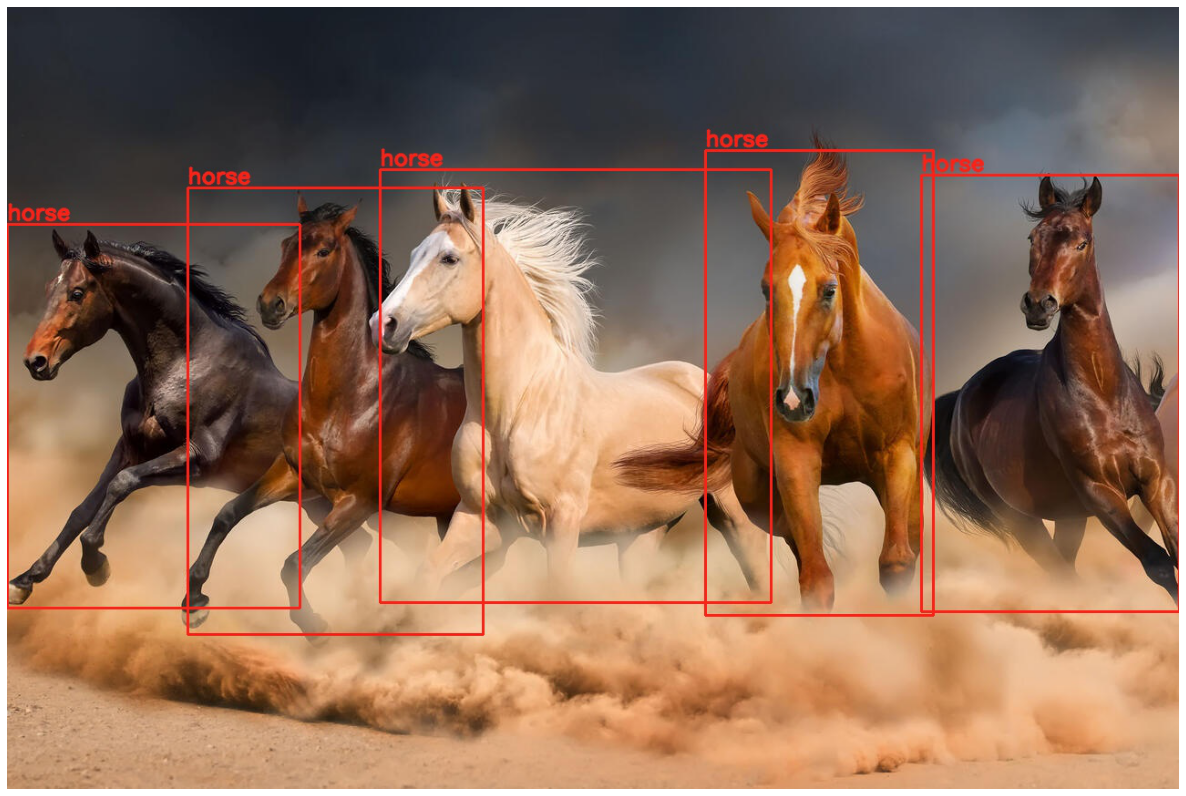

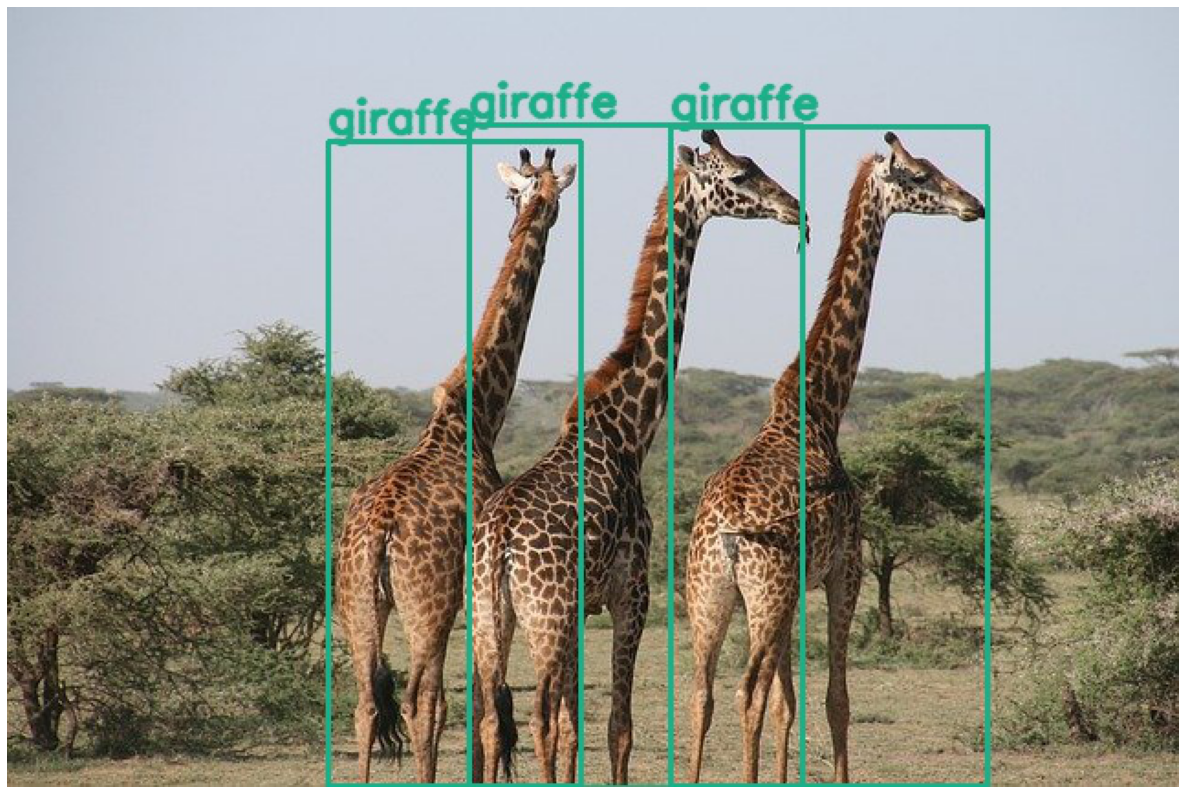

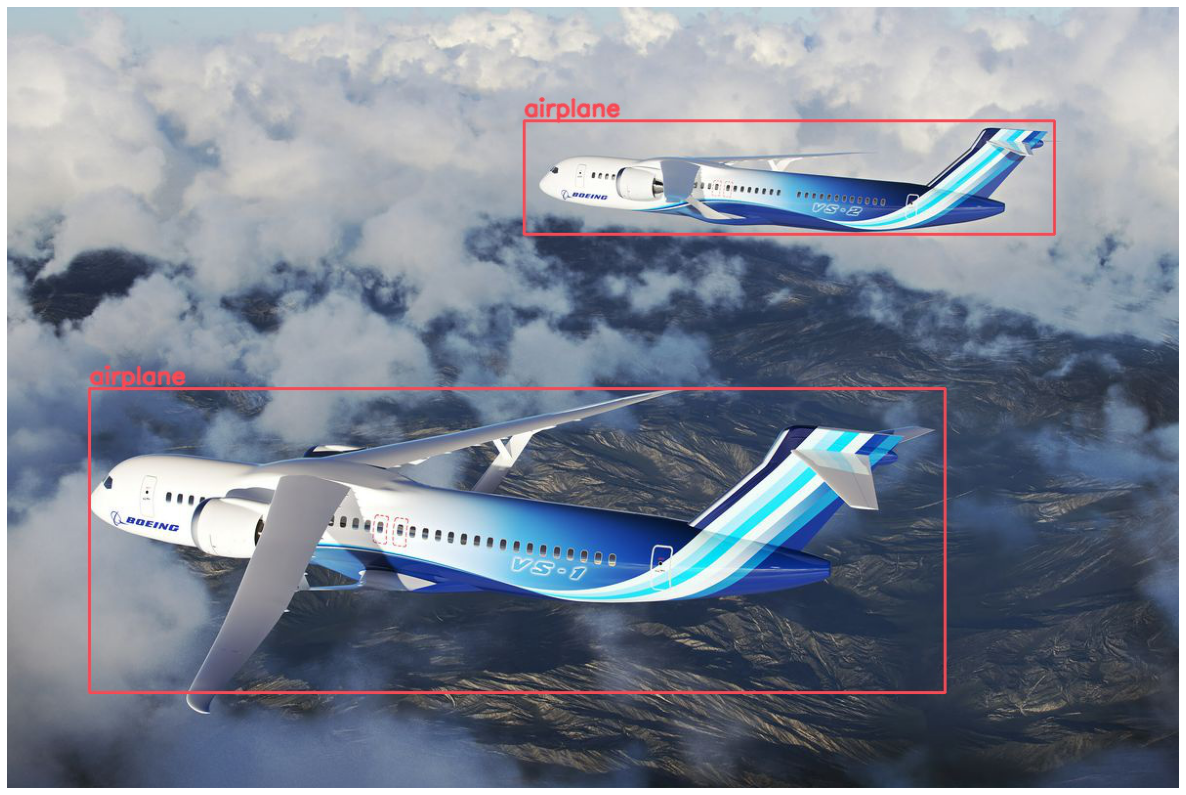

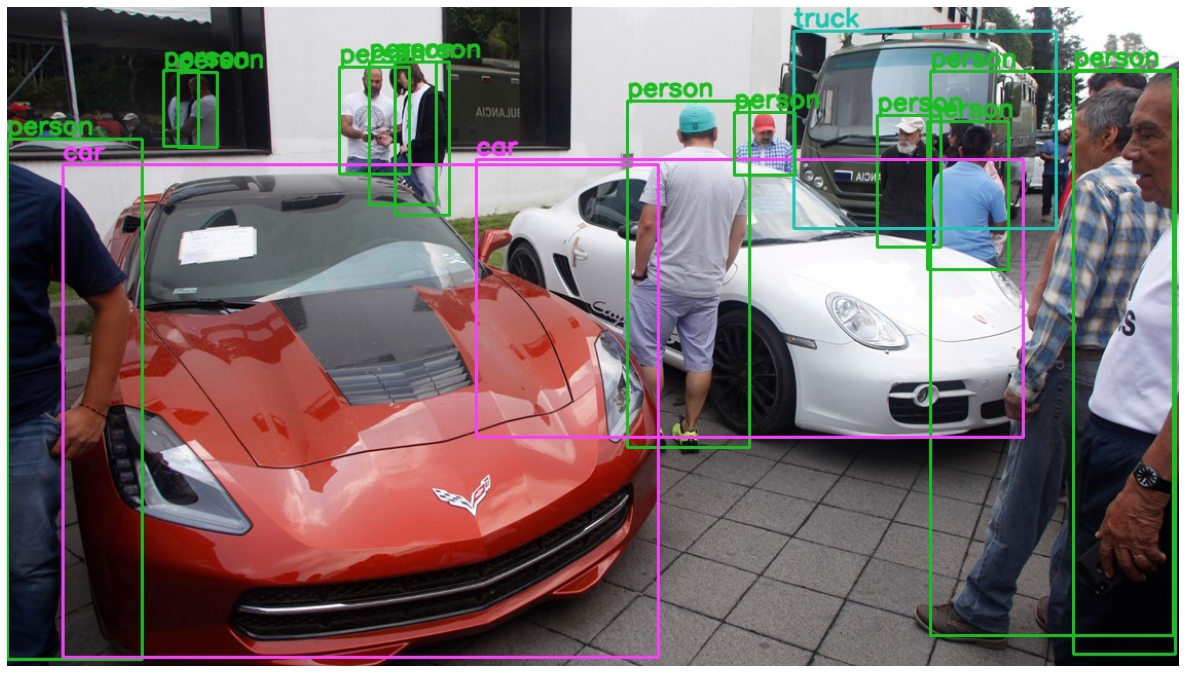

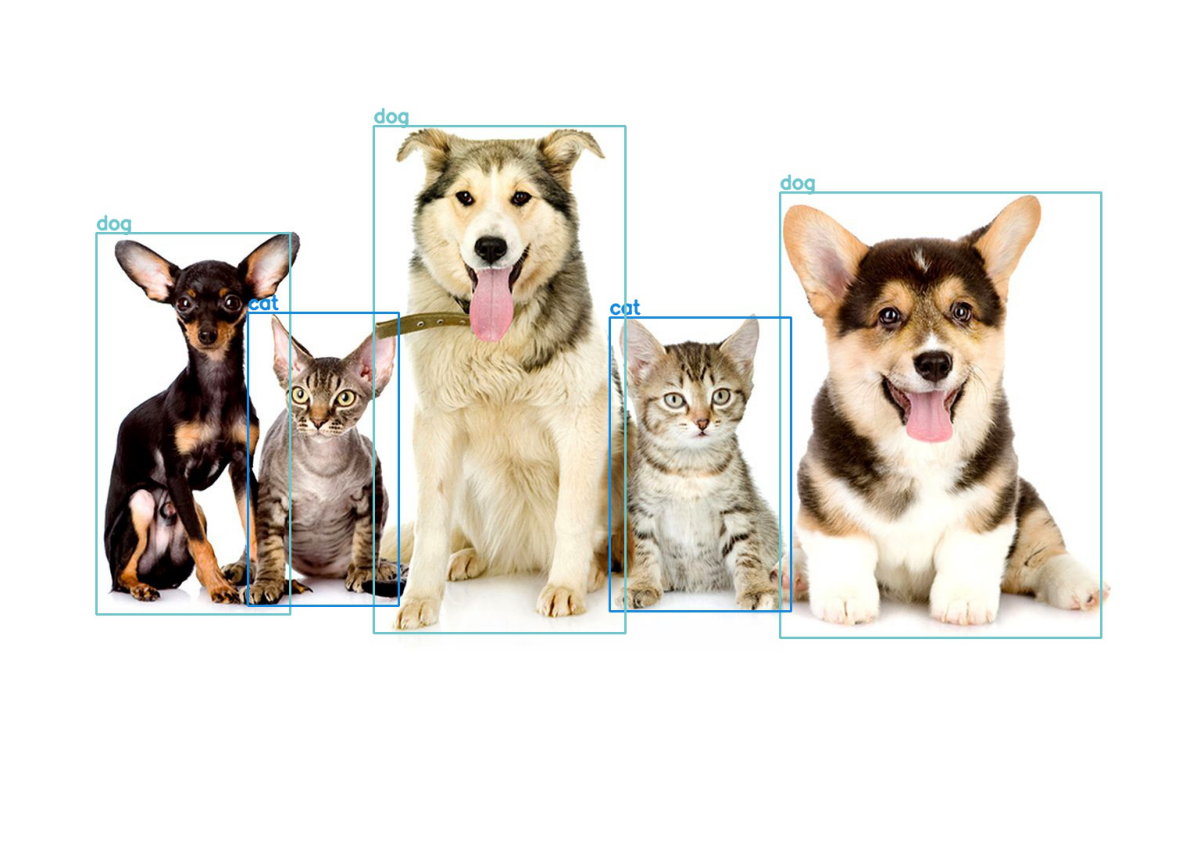

In [9]:
# смотрим итог проделаной работы 
image_1 = plt.imread('outputs/image_1.jpg')
image_2 = plt.imread('outputs/image_2.jpg')
image_3 = plt.imread('outputs/image_3.jpg')
image_4 = plt.imread('outputs/image_4.jpg')
image_5 = plt.imread('outputs/image_5.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()

plt.imshow(image_2)
plt.axis('off')
plt.show()

plt.imshow(image_3)
plt.axis('off')
plt.show()

plt.imshow(image_4)
plt.axis('off')
plt.show()

plt.imshow(image_5)
plt.axis('off')
plt.show()